# Перенос обучения

## Загрузка библиотек

In [ ]:
!pip install --upgrade pytorch-lightning
!pip install timm

     |████████████████████████████████| 526 kB 5.3 MB/s 
     |████████████████████████████████| 829 kB 44.9 MB/s 
     |████████████████████████████████| 596 kB 43.6 MB/s 
     |████████████████████████████████| 132 kB 53.7 MB/s 
     |████████████████████████████████| 332 kB 24.4 MB/s 
     |████████████████████████████████| 1.1 MB 41.0 MB/s 
     |████████████████████████████████| 160 kB 53.3 MB/s 
     |████████████████████████████████| 271 kB 53.7 MB/s 
     |████████████████████████████████| 192 kB 46.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=aab082f9ff60ad99b9f9c30699b8d74d92c15da11cfc09130377483733b52424
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [ ]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import os
import time
import glob

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import cv2
import pytorch_lightning as pl
import timm
# import torch as T
import torch.nn.functional as F
# from torch import nn
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms
from torchvision.utils import make_grid
from sklearn.model_selection import ShuffleSplit
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from PIL import Image

from typing import Tuple

%matplotlib inline

##Часть I. Предобученные сети как экстракторы признаков	

## Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/CV_project1_data.zip" -d "/content/data/"

unzip:  cannot find or open /content/drive/MyDrive/CV_project1_data.zip, /content/drive/MyDrive/CV_project1_data.zip.zip or /content/drive/MyDrive/CV_project1_data.zip.ZIP.


In [ ]:
path_train = "/content/data/data/train"
path_valid = "/content/data/data/valid"

In [ ]:
class_names = os.listdir(path_train)
class_names

['jeff_bezos', 'mark_zuckerberg', 'steve_jobs', 'bill_gates', 'elon_musk']

In [ ]:
print("Train count images ... ")
for ppl in os.listdir(path_train):
  print(ppl, ": ", len(os.listdir(os.path.join(path_train, ppl))), " examples.")

print("Valid count images ... ")
for ppl in os.listdir(path_valid):
  print(ppl, ": ", len(os.listdir(os.path.join(path_valid, ppl))), " examples.")

Train count images ... 
jeff_bezos :  600  examples.
mark_zuckerberg :  600  examples.
steve_jobs :  600  examples.
bill_gates :  600  examples.
elon_musk :  600  examples.
Valid count images ... 
jeff_bezos :  214  examples.
mark_zuckerberg :  217  examples.
steve_jobs :  66  examples.
bill_gates :  223  examples.
elon_musk :  194  examples.


In [ ]:
class_labels_mapping = {}
for k, v in zip(class_names, range(0,len(class_names)+1)):
    class_labels_mapping[k] = str(v)

class_labels_mapping

{'bill_gates': '3',
 'elon_musk': '4',
 'jeff_bezos': '0',
 'mark_zuckerberg': '1',
 'steve_jobs': '2'}

### Prepare training data for Dataset

In [ ]:
# Let's start from X (links to pictures)
# Training filenames
TRAINING_FILENAMES = []
TRAINING_LABELS = []
for class_name in class_names:  # range(1,N_CLASSES+1):
  path_to_class_data = os.path.join(path_train, class_name)
  files_inside = os.listdir(path_to_class_data)
  class_labels = [class_labels_mapping.get(class_name) for example in files_inside]
  files_inside = [os.path.join(path_train, class_name, file_name) for file_name in files_inside]
  TRAINING_FILENAMES.extend(files_inside)
  TRAINING_LABELS.extend(class_labels)
    
print(TRAINING_FILENAMES[:5])
print(TRAINING_LABELS[:5])
assert(len(TRAINING_LABELS) == len(TRAINING_FILENAMES))

['/content/data/data/train/jeff_bezos/10c6b44b-c161-4751-bcad-763068ceb3a1.jpg', '/content/data/data/train/jeff_bezos/b660c59f-7f4d-40b1-9603-b04bf925b039.jpg', '/content/data/data/train/jeff_bezos/b3f4eef6-04ca-46a2-9f29-db10e3f21823.jpg', '/content/data/data/train/jeff_bezos/32411bd2-bc93-468a-b58b-ed687ab1f2b1.jpg', '/content/data/data/train/jeff_bezos/0d9c5f2b-2ba1-4146-b2db-95750d92dd18.jpg']
['0', '0', '0', '0', '0']


### Prepare valid data for Dataset

In [ ]:
# Let's start from X (links to pictures)
# Training filenames
VALID_FILENAMES = []
VALID_LABELS = []
for class_name in class_names:  # range(1,N_CLASSES+1):
  path_to_class_data = os.path.join(path_valid, class_name)
  files_inside = os.listdir(path_to_class_data)
  class_labels = [class_labels_mapping.get(class_name) for example in files_inside]
  files_inside = [os.path.join(path_valid, class_name, file_name) for file_name in files_inside]
  VALID_FILENAMES.extend(files_inside)
  VALID_LABELS.extend(class_labels)
    
print(VALID_FILENAMES[:5])
print(VALID_LABELS[:5])
assert(len(VALID_LABELS) == len(VALID_FILENAMES))

['/content/data/data/valid/jeff_bezos/ef505f75-8e92-42ce-96a3-b3d331957ab2.jpg', '/content/data/data/valid/jeff_bezos/ccdecf4a-3501-4beb-bc36-7d18dae609f8.jpg', '/content/data/data/valid/jeff_bezos/c5e8ec9b-9968-4408-8bfd-d6abcb5806cf.jpg', '/content/data/data/valid/jeff_bezos/ec3ea451-2cb6-42f9-90cb-b3738187db33.jpg', '/content/data/data/valid/jeff_bezos/f7a8333e-649b-4dea-a367-ad26ad58571e.jpg']
['0', '0', '0', '0', '0']


In [ ]:
print(max([int(category) for category in TRAINING_LABELS]))
print(min([int(category) for category in TRAINING_LABELS]))

4
0


### Helper functions

In [ ]:
def imshow(img, if_normalized=False):
    if if_normalized == True:
        img = img / 2 + 0.5    # unnormalize
    else:
        img = img
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Define transformations

In [ ]:
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
BATCH_SIZE = 16

In [ ]:
basic_transforms = transforms.Compose([
    transforms.Resize([512,512]),
    transforms.ToTensor()
])

In [ ]:
class TrainValidDataset(Dataset):
  def __init__(self, image_paths,
               transforms,
               labels):
    self.image_paths = image_paths
    self.transforms = transforms
    self.labels = labels

  def __len__(self):
    return(len(self.image_paths))

  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx])
    image = self.transforms(image)
    category = self.labels[idx]
    return (torch.FloatTensor(image), torch.tensor(int(category)))

In [ ]:
# Train loaders
TRAIN_DATASET = TrainValidDataset(image_paths=TRAINING_FILENAMES,
                          transforms = basic_transforms,
                          labels=TRAINING_LABELS)
TRAIN_LOADER = torch.utils.data.DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE,shuffle=True)


# Validation loaders
VALID_DATASET = TrainValidDataset(image_paths=VALID_FILENAMES,
                          transforms = basic_transforms,
                          labels=VALID_LABELS)
VALID_LOADER = torch.utils.data.DataLoader(VALID_DATASET, batch_size=BATCH_SIZE,shuffle=True)

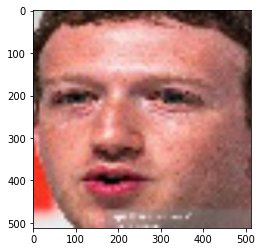

In [ ]:
imgs, categories = next(iter(TRAIN_LOADER))
imshow(imgs[0])

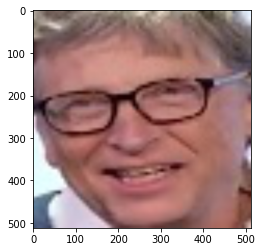

In [ ]:
imgs, categories = next(iter(VALID_LOADER))
imshow(imgs[2])

### Make corrections with normalization

In [ ]:
from typing import Tuple
from tqdm import tqdm

In [ ]:
def mean_std_of_dataset(dataset: Dataset) -> Tuple[torch.Tensor, torch.Tensor]:
    mean = 0.0
    var = 0.0
    for img, label in tqdm(dataset):
        img_channel_flat = img.view(img.size(0), -1)
        mean += img_channel_flat.mean(1)
        var += img_channel_flat.var(1)
    mean /= len(dataset)
    var /= len(dataset)
    std = var.sqrt()
    return mean, std

In [ ]:
train_means, train_stds = mean_std_of_dataset(VALID_DATASET)
print(f'Means: {train_means}')
print(f'Stds: {train_stds}')

100%|██████████| 914/914 [00:14<00:00, 62.64it/s]


Means: tensor([0.6389, 0.4880, 0.4375])
Stds: tensor([0.2086, 0.1830, 0.1764])


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize([512,512]),
    # transforms.CenterCrop(224),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation((-15,15)),
    # transforms.RandomGrayscale(p=0.2),
    # transforms.RandomVerticalFlip(p=0.2),
    # transforms.RandomEqualize(p=0.2),
    # transforms.RandomInvert(p=0.2),
    transforms.RandomAutocontrast(p=0.2),
    # transforms.ColorJitter(contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(train_means, train_stds)
])

validTest_transforms = transforms.Compose([
    transforms.Resize([512,512]),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(train_means, train_stds)
])

In [ ]:
# Train loaders
TRAIN_DATASET = TrainValidDataset(image_paths=TRAINING_FILENAMES,
                          transforms = train_transforms,
                          labels=TRAINING_LABELS)
TRAIN_LOADER = torch.utils.data.DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE,shuffle=True)


# Validation loaders
VALID_DATASET = TrainValidDataset(image_paths=VALID_FILENAMES,
                          transforms = validTest_transforms,
                          labels=VALID_LABELS)
VALID_LOADER = torch.utils.data.DataLoader(VALID_DATASET, batch_size=BATCH_SIZE,shuffle=False)

## Check the loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


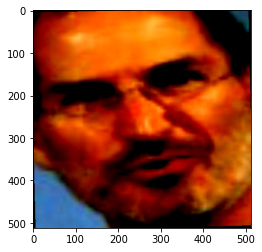

Class of this image:  tensor(2)


In [ ]:
imgs, categories = next(iter(TRAIN_LOADER))
imshow(imgs[0], if_normalized=True)

print("Class of this image: ", categories[0])

In [ ]:
VALID_LOADER.__len__()  

58

In [ ]:
TRAIN_LOADER.__len__()  

188

## Modelling

In [ ]:
gpu_num = min(1, torch.cuda.device_count())
gpu_num

1

In [ ]:
class TrainingModule(pl.LightningModule):
    def __init__(self, net: nn.Module, lr_scheduler_cls=None, lr_scheduler_kwargs={}, lr: float = 3e-4,
                 params_to_optimize=None):
        super().__init__()
        self.net = net
        self.loss = nn.CrossEntropyLoss()
        self.lr = lr
        self.lr_scheduler_cls = lr_scheduler_cls
        self.lr_scheduler_kwargs = lr_scheduler_kwargs
        self.params_to_optimize = params_to_optimize
#         self.save_hyperparameters()

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        images, target = batch
        output = self(images)
        loss = self.loss(output, target)
        with torch.no_grad():
            top1 = torch.mean((output.argmax(1) == target).float()).item()

        self.log('train/loss', loss, on_step=False, on_epoch=True)
        self.log('train/top1', top1, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, target = batch

        output = self(images)
        loss = self.loss(output, target)
        top1 = torch.mean((output.argmax(1) == target).float()).item()

        self.log('val/loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val/top1', top1, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        if self.params_to_optimize is not None:
            params_to_optimize = self.params_to_optimize 
        else:
            params_to_optimize = (param for param in self.net.parameters() if param.requires_grad)
        optimizer = torch.optim.Adam(params_to_optimize,
                            lr=self.lr)
        if self.lr_scheduler_cls is not None:
            return [optimizer], [self.lr_scheduler_cls(optimizer, **self.lr_scheduler_kwargs)]
        else:
            return optimizer

### Densenet

In [ ]:
densenet = models.densenet161(pretrained=True)
densenet.features.requires_grad_(False)
densenet.classifier = nn.Sequential(
    nn.Linear(2208, len(class_names)),
    nn.Softmax(-1)
)
densenet;

In [ ]:
class DenseNetFinetuning(pl.callbacks.BaseFinetuning):
    def __init__(self, unfreeze_at_epoch=50, initial_denom_lr=1.0):
        super().__init__()
        self.unfreeze_at_epoch = unfreeze_at_epoch
        self.initial_denom_lr = initial_denom_lr
        
    def freeze_before_training(self, pl_module):
        print('Freezing weights')
        self.freeze(pl_module.net.features)
    
    def finetune_function(self, pl_module, current_epoch, optimizer, optimizer_idx):
        if current_epoch == self.unfreeze_at_epoch:
            print('Unfreezing weights')
            self.unfreeze_and_add_param_group(
                modules=pl_module.net.features,
                optimizer=optimizer,
                initial_denom_lr=self.initial_denom_lr
            )

In [ ]:
training_module = TrainingModule(densenet, 
                                        lr_scheduler_cls=T.optim.lr_scheduler.MultiStepLR,
                                        lr_scheduler_kwargs=dict(
                                            milestones=[10, 20, 25, 30, 35, 40, 50, 70, 90],
                                            gamma=0.2
                                        ),
                                        lr=1e-3,
                                        params_to_optimize=densenet.classifier.parameters()
)
trainer = pl.Trainer(
    gpus=gpu_num,
    max_epochs=50,
    logger=pl.loggers.CSVLogger('logs', 'pretrained_densenet'),
#     auto_lr_find=True, 
    callbacks=[
        pl.callbacks.progress.TQDMProgressBar(refresh_rate=20),
        pl.callbacks.EarlyStopping('val/loss', patience=5, verbose=True),
        pl.callbacks.LearningRateMonitor(logging_interval='epoch', log_momentum=True),
        DenseNetFinetuning(unfreeze_at_epoch=25, initial_denom_lr=5.0)
    ]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(training_module, TRAIN_LOADER, VALID_LOADER)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Freezing weights



  | Name | Type             | Params
------------------------------------------
0 | net  | DenseNet         | 26.5 M
1 | loss | CrossEntropyLoss | 0     
------------------------------------------
230 K     Trainable params
26.3 M    Non-trainable params
26.5 M    Total params
105.932   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved. New best score: 1.274


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.115 >= min_delta = 0.0. New best score: 1.159


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.033 >= min_delta = 0.0. New best score: 1.127


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.017 >= min_delta = 0.0. New best score: 1.109


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.040 >= min_delta = 0.0. New best score: 1.069


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.028 >= min_delta = 0.0. New best score: 1.041


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.008 >= min_delta = 0.0. New best score: 1.033


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 1.030


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.011 >= min_delta = 0.0. New best score: 1.019


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 1.017


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 1.014


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 1.010


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 1.009


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 1.009


Validating: 0it [00:00, ?it/s]

Unfreezing weights


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.014 >= min_delta = 0.0. New best score: 0.995


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.007 >= min_delta = 0.0. New best score: 0.987


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.012 >= min_delta = 0.0. New best score: 0.976


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.971


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.008 >= min_delta = 0.0. New best score: 0.963


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.962


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.958


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.957


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.957


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.955


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.955


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.953


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# Validation loaders
VALID_DATASET = TrainValidDataset(image_paths=VALID_FILENAMES,
                          transforms = validTest_transforms,
                          labels=VALID_LABELS)
VALID_LOADER = torch.utils.data.DataLoader(VALID_DATASET, batch_size=2,shuffle=False)

In [ ]:
predictions = []
labels = []
for img, lbls in tqdm(VALID_LOADER):
        probs = densenet(img)
        predictions.extend(probs.argmax(-1).tolist())
        labels.extend(lbls)           

100%|██████████| 457/457 [08:21<00:00,  1.10s/it]


In [ ]:
import pandas as pd

print(len(predictions), len(labels))
data = pd.DataFrame({'Id': labels, 'Category': predictions})
print(data.head(15))

914 914
           Id  Category
0   tensor(0)         0
1   tensor(0)         0
2   tensor(0)         0
3   tensor(0)         4
4   tensor(0)         0
5   tensor(0)         0
6   tensor(0)         4
7   tensor(0)         0
8   tensor(0)         0
9   tensor(0)         0
10  tensor(0)         0
11  tensor(0)         0
12  tensor(0)         0
13  tensor(0)         3
14  tensor(0)         2


In [ ]:
data.Id = data.Id.apply(lambda x: x.item())

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy score on the test sample is: ", accuracy_score(data.Id, data.Category))

Accuracy score on the test sample is:  0.7219589385935801


In [ ]:
# Let's visualize one sample picture with prediction made by model

imgs, categories = next(iter(VALID_LOADER))
probs = densenet(imgs[0])
prediction = probs.argmax(-1).tolist()
imshow(imgs[0], if_normalized=True)

print("Real class of this image: ", categories[0], " and predicted class is:", prediction)

Anyway, our model is not good enough (Accuracy is lower than 0.85), so let's move further with another one architecture - EfficientNet.

### Efficientnet

In [ ]:
efficientnet = timm.create_model('efficientnet_b2', pretrained=True)
efficientnet.blocks.requires_grad_(False)
efficientnet.classifier = nn.Sequential(
    nn.Linear(efficientnet.classifier.in_features, len(class_names)),
    nn.Softmax(-1)
)
efficientnet;

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


In [ ]:
efficientnet.classifier

Sequential(
  (0): Linear(in_features=1408, out_features=5, bias=True)
  (1): Softmax(dim=-1)
)

In [ ]:
class DictFinetuning(pl.callbacks.BaseFinetuning):
    def __init__(self, epoch_to_config, initial_denom_lr=1.0):
        super().__init__()
        self.epoch_to_config = epoch_to_config
        self.initial_denom_lr = initial_denom_lr
        
    def freeze_before_training(self, pl_module):
        print('Freezing weights')
        for cfg in self.epoch_to_config.values():
            module = cfg['module']
            self.freeze(module)
    
    def finetune_function(self, pl_module, current_epoch, optimizer, optimizer_idx):
        cfg = self.epoch_to_config.get(current_epoch, None)
        if cfg is not None:
            print(f'Unfreezing weights at epoch {current_epoch}')
            self.unfreeze_and_add_param_group(
                modules=cfg['module'],
                optimizer=optimizer,
                initial_denom_lr=cfg.get('initial_denom_lr', self.initial_denom_lr)
            )

In [ ]:
training_module = TrainingModule(efficientnet, 
#                                         lr_scheduler_cls=T.optim.lr_scheduler.MultiStepLR,
#                                         lr_scheduler_kwargs=dict(
#                                             milestones=[10, 15, 20, 25, 30, 35, 40, 50, 70, 90],
#                                             gamma=0.3
#                                         ),
                                        lr=1e-3,
                                        params_to_optimize=efficientnet.classifier.parameters()
)
trainer = pl.Trainer(
    gpus=gpu_num,
    max_epochs=100,
    logger=pl.loggers.CSVLogger('logs', 'pretrained_efficientnet'),
#     auto_lr_find=True, 
    callbacks=[
        pl.callbacks.progress.TQDMProgressBar(refresh_rate=20),
        pl.callbacks.EarlyStopping('val/loss', patience=10, verbose=True),
        pl.callbacks.LearningRateMonitor(logging_interval='epoch', log_momentum=True),
        DictFinetuning({
            10: {'module': efficientnet.conv_head},
            15: {'module': efficientnet.blocks[-1][1]},
            20: {'module': efficientnet.blocks[-1][0]},
            25: {'module': efficientnet.blocks[-2][-3:]},
            30: {'module': efficientnet.blocks[-2][:-3]},
            35: {'module': efficientnet.blocks[-3][-2:]},
            40: {'module': efficientnet.blocks[-3][:-2]}
        }, initial_denom_lr=10.0)
    ]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(training_module, TRAIN_LOADER, VALID_LOADER)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Freezing weights



  | Name | Type             | Params
------------------------------------------
0 | net  | EfficientNet     | 7.7 M 
1 | loss | CrossEntropyLoss | 0     
------------------------------------------
62.3 K    Trainable params
7.6 M     Non-trainable params
7.7 M     Total params
30.832    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved. New best score: 1.392


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.049 >= min_delta = 0.0. New best score: 1.343


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.057 >= min_delta = 0.0. New best score: 1.286


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.060 >= min_delta = 0.0. New best score: 1.226


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.021 >= min_delta = 0.0. New best score: 1.205


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.012 >= min_delta = 0.0. New best score: 1.193


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.011 >= min_delta = 0.0. New best score: 1.182


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.009 >= min_delta = 0.0. New best score: 1.173


Unfreezing weights at epoch 10


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.016 >= min_delta = 0.0. New best score: 1.157


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.014 >= min_delta = 0.0. New best score: 1.143


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.030 >= min_delta = 0.0. New best score: 1.113


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.024 >= min_delta = 0.0. New best score: 1.090


Validating: 0it [00:00, ?it/s]

Unfreezing weights at epoch 15


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.045 >= min_delta = 0.0. New best score: 1.045


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.017 >= min_delta = 0.0. New best score: 1.028


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.046 >= min_delta = 0.0. New best score: 0.982


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.010 >= min_delta = 0.0. New best score: 0.971


Validating: 0it [00:00, ?it/s]

Unfreezing weights at epoch 20


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.012 >= min_delta = 0.0. New best score: 0.959


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.014 >= min_delta = 0.0. New best score: 0.945


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.944


Unfreezing weights at epoch 25


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.008 >= min_delta = 0.0. New best score: 0.936


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.010 >= min_delta = 0.0. New best score: 0.925


Validating: 0it [00:00, ?it/s]

Unfreezing weights at epoch 30


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.922


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.917


Unfreezing weights at epoch 35


Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.915


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val/loss improved by 0.001 >= min_delta = 0.0. New best score: 0.914


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Unfreezing weights at epoch 40


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val/loss did not improve in the last 10 records. Best score: 0.914. Signaling Trainer to stop.


In [ ]:
# Validation loaders
VALID_DATASET = TrainValidDataset(image_paths=VALID_FILENAMES,
                          transforms = validTest_transforms,
                          labels=VALID_LABELS)
VALID_LOADER = torch.utils.data.DataLoader(VALID_DATASET, batch_size=2,shuffle=False)

In [ ]:
predictions = []
labels = []
for img, lbls in tqdm(VALID_LOADER):
        probs = efficientnet(img)
        predictions.extend(probs.argmax(-1).tolist())
        labels.extend(lbls)           

100%|██████████| 457/457 [09:39<00:00,  1.27s/it]


In [ ]:
import pandas as pd

data = pd.DataFrame({'Id': labels, 'Category': predictions})
data.Id = data.Id.apply(lambda x: x.item())
data.to_csv("predictions.csv", encoding="utf-8")

# Let's check some of the predicted images with its' labels

In [ ]:
data.set_index('Id', inplace=True)

In [ ]:
class CheckValidDataset(Dataset):
  def __init__(self, image_paths,
               transforms,
               labels):
    self.image_paths = image_paths
    self.transforms = transforms
    self.labels = labels

  def __len__(self):
    return(len(self.image_paths))

  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx])
    image = self.transforms(image)
    category = self.labels[idx]
    return (torch.FloatTensor(image), torch.tensor(int(category)), self.image_paths[idx])

In [ ]:
labels_class_maping = {}
vals = class_labels_mapping.values()
keys = class_labels_mapping.keys()
for k, v in zip(keys, vals):
  labels_class_maping[v] = k

labels_class_maping

{'0': 'bill_gates',
 '1': 'mark_zuckerberg',
 '2': 'elon_mask',
 '3': 'steve_jobs',
 '4': 'jeff_bezos'}

In [ ]:
BATCH_SIZE=10

# Validation loaders
VALID_DATASET = CheckValidDataset(image_paths=VALID_FILENAMES,
                          transforms = basic_transforms,
                          labels=VALID_LABELS)
VALID_LOADER = torch.utils.data.DataLoader(VALID_DATASET, batch_size=BATCH_SIZE,shuffle=True)

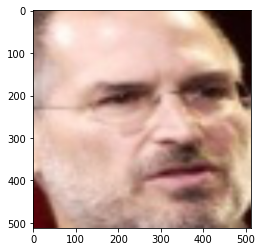

Identified person on this image is :  steve_jobs
Real person on this image is :  steve_jobs


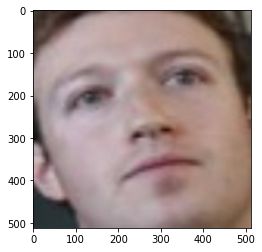

Identified person on this image is :  mark_zuckerberg
Real person on this image is :  mark_zuckerberg


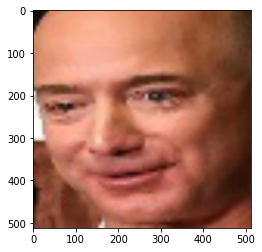

Identified person on this image is :  jeff_bezos
Real person on this image is :  jeff_bezos


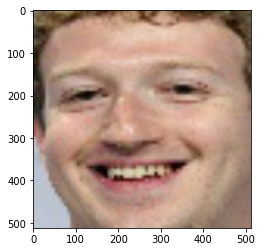

Identified person on this image is :  mark_zuckerberg
Real person on this image is :  mark_zuckerberg


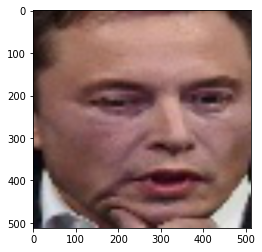

Identified person on this image is :  elon_mask
Real person on this image is :  elon_mask


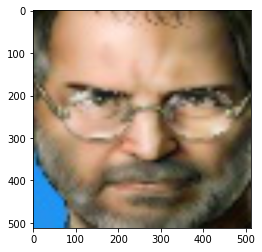

Identified person on this image is :  steve_jobs
Real person on this image is :  steve_jobs


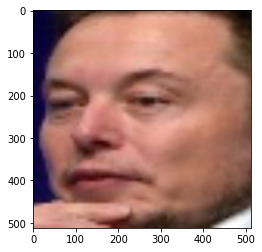

Identified person on this image is :  elon_mask
Real person on this image is :  elon_mask


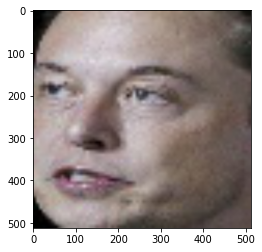

Identified person on this image is :  elon_mask
Real person on this image is :  elon_mask


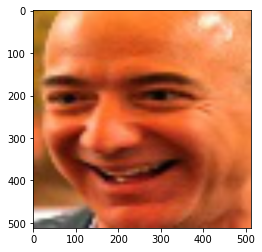

Identified person on this image is :  elon_mask
Real person on this image is :  jeff_bezos


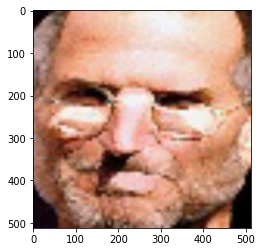

Identified person on this image is :  steve_jobs
Real person on this image is :  steve_jobs


In [ ]:
imgs, categories, image_paths = next(iter(VALID_LOADER))
for i in range(10):
  imshow(imgs[i], if_normalized=False)

  print("Identified person on this image is : ", labels_class_maping[str(data.at[image_paths[i], "Category"])])
  print("Real person on this image is : ", labels_class_maping[str(categories[i].item())])

On these images we can see 1 fail of our model - it recognizes once Jeff Bezos as Elon Mask :) Others samples are OK!

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy score on the test sample is: ", accuracy_score(data.Id, data.Category))

Accuracy score on the test sample is:  0.8827467646276574


So for prediction the best score was reached by EfficientNet - 0.88!